# Posture Recognition and Finger Sliding Workspace

## Useful Resources

 - [Batch and Epoch training metrics for transformers Trainer](https://stackoverflow.com/questions/78311534/batch-and-epoch-training-metrics-for-transformers-trainer)
 - [Huggingface Trainer(): K-Fold Cross Validation](https://stackoverflow.com/questions/75510487/huggingface-trainer-k-fold-cross-validation)
 - [Metrics for Training Set in Trainer](https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461)
 - [Huggingface: Datasets](https://huggingface.co/docs/datasets/v2.12.0/en/installation)
 - [Hugginface: Transformers - Trainer API](https://huggingface.co/docs/transformers/trainer)

## 0. Import Library

In [1]:
import torch
import transformers
import numpy as np
import einops
import os
import datasets
import seedir as sd
import glob
import albumentations as A

from datasets import Dataset

## 1. Create Dataset Object

### Posture Recognition (Image Classification)

In [2]:
from datasets import Image

# 1) Load filepaths and labels (you already have this)
rgb_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image\rgb'

filepaths, labels = [], []
for class_name in os.listdir(rgb_dir):
    class_dir = os.path.join(rgb_dir, class_name)
    for npy_path in glob.glob(os.path.join(class_dir, '*.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

# 2) Create Hugging‑Face Dataset
arrays = [np.load(p) for p in filepaths]
pr_ds = Dataset.from_dict({
    "image": arrays,
    "label": labels
})

# 1) initial 80/20 split
split1 = pr_ds.train_test_split(test_size=0.2, shuffle=True, seed=42)
train_ds = split1["train"]        # 80%
temp_ds  = split1["test"]         # 20%

# 2) split that 20% into half validation, half test → 10/10
split2 = temp_ds.train_test_split(test_size=0.5, shuffle=True, seed=42)
val_ds  = split2["train"]         # 10%
test_ds = split2["test"]          # 10%

# 4) Build label2id / id2label
unique_labels = sorted(set(labels))
label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

### Finger Sliding Workspace (Video Classification)

## 2. Load Model

### Image

In [3]:
from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification
from torchinfo import summary
import torch
import copy

pr_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
# pr_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
pr_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

print(pr_model.config)

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Send model to the same device as input
pr_model_eval = copy.deepcopy(pr_model)
pr_model_eval.eval()

# Print model summary
summary(pr_model_eval, input_data=dummy_input, depth=3, col_names=["input_size", "output_size", "num_params"])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Hand_Close",
    "1": "Hand_Open",
    "2": "Hook_Hand",
    "3": "Intrinsic_Plan",
    "4": "Straight_Fist"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Hand_Close": 0,
    "Hand_Open": 1,
    "Hook_Hand": 2,
    "Intrinsic_Plan": 3,
    "Straight_Fist": 4
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}



Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
ViTForImageClassification                               [1, 3, 224, 224]          [1, 5]                    --
├─ViTModel: 1-1                                         [1, 3, 224, 224]          [1, 197, 768]             --
│    └─ViTEmbeddings: 2-1                               [1, 3, 224, 224]          [1, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [1, 3, 224, 224]          [1, 196, 768]             590,592
│    │    └─Dropout: 3-2                                [1, 197, 768]             [1, 197, 768]             --
│    └─ViTEncoder: 2-2                                  [1, 197, 768]             [1, 197, 768]             --
│    │    └─ModuleList: 3-3                             --                        --                        85,054,464
│    └─LayerNorm: 2-3                                   [1, 197, 768]             [1, 197

### Video

## 3. Apply Augmentation

### Image

**Set up Transformation Pipeline with Albumentations**

C:\Users\11208120\AppData\Local\Temp\ipykernel_27840\4136661991.py:21: UserWarning: Argument(s) 'threshold' are not valid for transform Solarize
  A.Solarize(threshold=128, p=1.0),


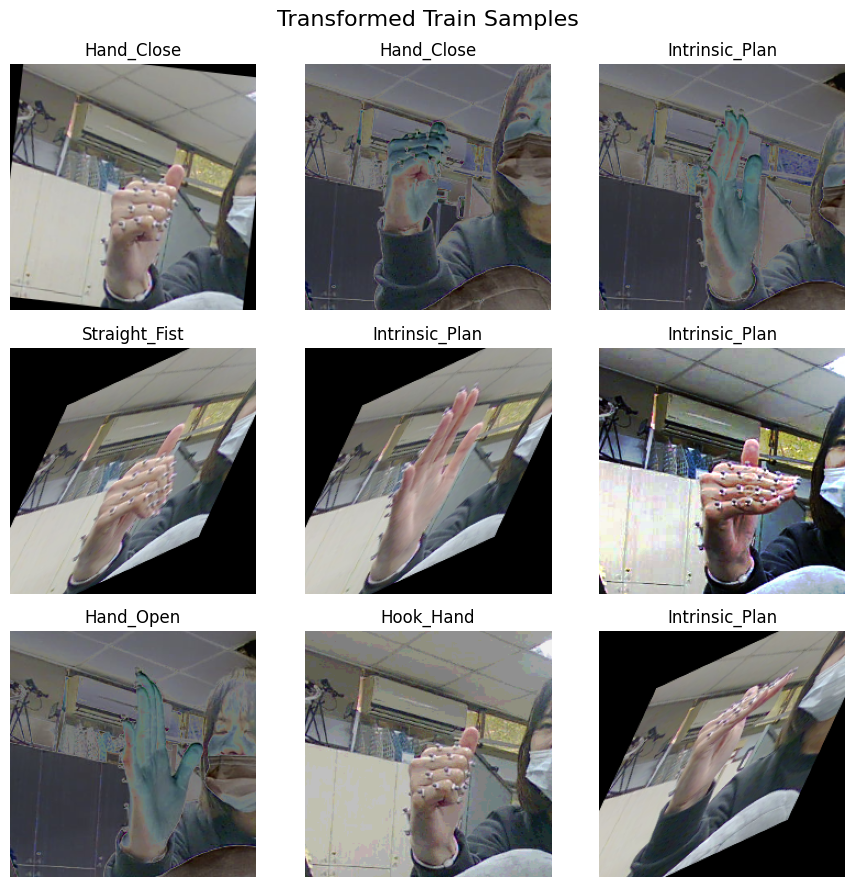

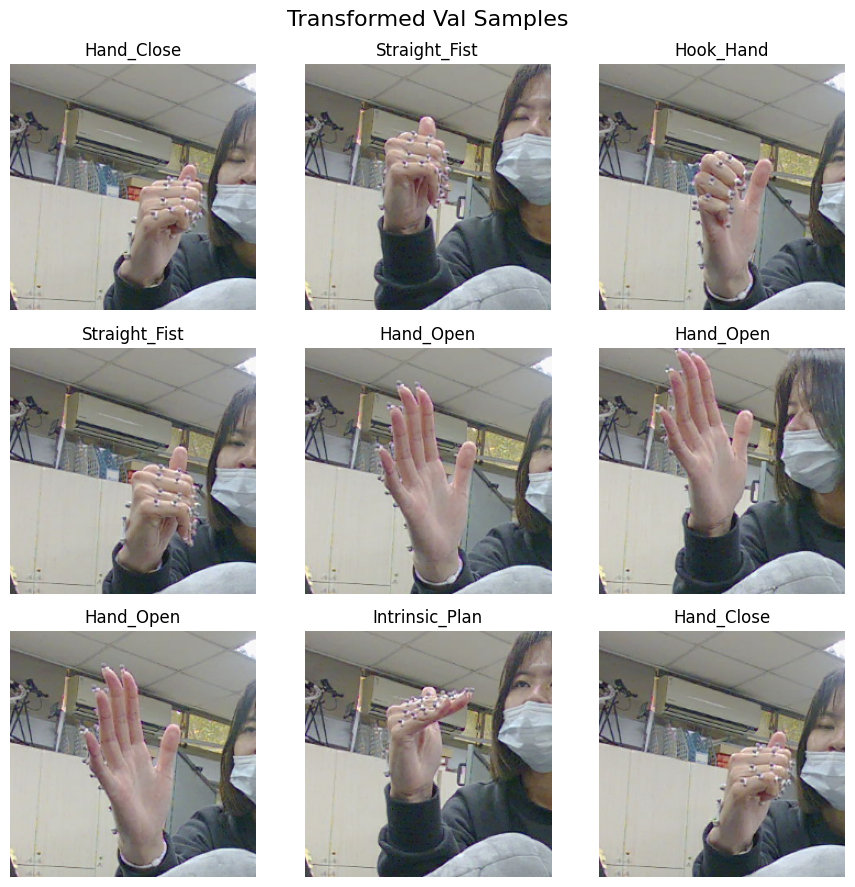

In [4]:
mean = pr_processor.image_mean
std = pr_processor.image_std
size = pr_processor.size
h, w = pr_processor.size["height"], pr_processor.size["width"]

train_transform = A.Compose([
    A.Resize(h, w),

    # pick exactly one of these (p=1 ensures one op always applied)
    A.OneOf([
        A.NoOp(),

        A.Affine(shear=25, p=1.0),        # ShearX/Y combined
        A.Affine(translate_percent={"x":0.2,"y":0}, p=1.0),  # TranslateX
        A.Affine(translate_percent={"x":0,"y":0.2}, p=1.0),  # TranslateY
        A.Rotate(limit=45, p=1.0),

        A.Sharpen(p=1.0),

        A.Posterize(num_bits=4, p=1.0),
        A.Solarize(threshold=128, p=1.0),
        A.Equalize(p=1.0),
    ], p=1.0),

    A.Normalize(mean=mean, std=std),
    A.ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(h, w),
    A.Normalize(mean=mean, std=std),
    A.ToTensorV2()
])

import random
import matplotlib.pyplot as plt

def show_grid_transformed(ds, transform, title):
    idxs = random.sample(range(len(ds)), k=min(9, len(ds)))
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle(title, fontsize=16)

    for ax, idx in zip(axes.ravel(), idxs):
        item = ds[idx]
        img = np.array(item["image"]).astype(np.uint8)
        label = item["label"]

        # Apply the Albumentations transform
        transformed = transform(image=img)["image"]

        # If normalized, unnormalize for display
        if transformed.max() <= 2 and transformed.min() >= -2:  # rough check
            transformed = transformed.permute(1, 2, 0).numpy()
            transformed = transformed * std + mean
            transformed = np.clip(transformed, 0, 1)
        else:
            transformed = transformed.transpose(1, 2, 0)

        ax.imshow(transformed)
        ax.set_title(label)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage:
show_grid_transformed(train_ds, train_transform, "Transformed Train Samples")
show_grid_transformed(val_ds, val_transform,  "Transformed Val Samples")

**Apply the Transformation Pipeline to Dataset**

In [5]:
def preprocess_train(batch):
    imgs = []
    for img in batch["image"]:
        arr = np.array(img, copy=False)
        if arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        imgs.append(train_transform(image=arr)["image"])

    batch["pixel_values"] = imgs
    batch["labels"]       = [label2id[l] for l in batch["label"]]
    return batch

def preprocess_val(batch):
    imgs = []
    for img in batch["image"]:
        arr = np.array(img, copy=False)
        if arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        imgs.append(val_transform(image=arr)["image"])

    batch["pixel_values"] = imgs
    batch["labels"]       = [label2id[l] for l in batch["label"]]
    return batch

# map & reassign train_ds
train_ds = train_ds.map(
    preprocess_train,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
train_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# map & reassign val_ds
val_ds = val_ds.map(
    preprocess_val,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
val_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# map & reassign test_ds
test_ds = test_ds.map(
    preprocess_val,
    batched=True,
    batch_size=8,
    remove_columns=["image", "label"]
)
test_ds.set_format(type="torch", columns=["pixel_values","labels"])


Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

### Video

## 4. Fine-Tuning Model

### Image

**Setup `TrainingArguments`, `Trainer`, and `evaluate`**

In [6]:
from transformers import Trainer, TrainerCallback, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import evaluate
from datetime import datetime
import pickle

model_ckpt = 'google/vit-base-patch16-224-in21k'
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-pr240"
num_train_epochs = 50
EXPERIMENT_DATE = datetime.now().strftime("%Y%m%d")
SAVE_DIR = f"experiments/image/{EXPERIMENT_DATE}/{new_model_name}"
batch_size = 8

args_pr = TrainingArguments(
    output_dir=SAVE_DIR,
    remove_unused_columns=False, 
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(
                         predictions=preds,
                         references=labels,
                         average="macro"    # or "weighted", depending on your needs
                     )["precision"],
        "recall":    recall.compute(
                         predictions=preds,
                         references=labels,
                         average="macro"
                     )["recall"],
        "f1":        f1.compute(
                         predictions=preds,
                         references=labels,
                         average="macro"
                     )["f1"],
    }

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # these will accumulate _all_ batches in the current epoch
        self.epoch_losses     = []
        self.epoch_preds      = []
        self.epoch_labels     = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Overrides Trainer.compute_loss to store batch‐level loss & preds/labels.
        """
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss   = outputs.loss
        logits = outputs.logits

        if labels is not None:
            # 1) store the loss
            self.epoch_losses.append(loss.item())
            # 2) store predictions + labels as 1D arrays
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs  = labels.detach().cpu().numpy()
            self.epoch_preds .extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())

        return (loss, outputs) if return_outputs else loss

class MetricsCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

        # lists to hold epoch‐by‐epoch values
        self.train_losses     = []
        self.train_accuracies = []
        self.eval_losses      = []
        self.eval_accuracies  = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average training loss & accuracy for the epoch
        t = self.trainer
        avg_loss = float(np.mean(t.epoch_losses))
        acc      = np.mean(
            np.array(t.epoch_preds) == np.array(t.epoch_labels)
        )

        # Store & clear for next epoch
        self.train_losses    .append(avg_loss)
        self.train_accuracies.append(acc)
        t.epoch_losses .clear()
        t.epoch_preds  .clear()
        t.epoch_labels .clear()

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # metrics come prefixed with "eval_"
        self.eval_losses   .append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])

trainer = CustomTrainer(
    model=pr_model,                 
    args=args_pr,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=pr_processor,          
    compute_metrics=compute_metrics, 
)

metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

C:\Users\11208120\AppData\Local\Temp\ipykernel_27840\694993208.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


**Training**

In [7]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.583100,1.645589,0.208333,0.220000,0.320000,0.186364
2,1.474000,1.440611,0.416667,0.500000,0.622222,0.397143
3,1.199700,1.101628,0.875000,0.880000,0.900000,0.847619
4,0.932600,0.702402,1.000000,1.000000,1.000000,1.000000
5,0.579400,0.380599,1.000000,1.000000,1.000000,1.000000
6,0.375200,0.240464,1.000000,1.000000,1.000000,1.000000
7,0.211600,0.124548,1.000000,1.000000,1.000000,1.000000
8,0.117700,0.090387,1.000000,1.000000,1.000000,1.000000
9,0.085200,0.073564,1.000000,1.000000,1.000000,1.000000
10,0.067500,0.064243,1.000000,1.000000,1.000000,1.000000


d:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\pyorbbecsdk\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\pyorbbecsdk\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**History Saving and Plotting**

In [8]:
history = {
    "train_loss":     metrics_cb.train_losses,
    "train_accuracy": metrics_cb.train_accuracies,
    "eval_loss":      metrics_cb.eval_losses,
    "eval_accuracy":  metrics_cb.eval_accuracies,
}
history_path = os.path.join(SAVE_DIR, "history.pkl")

# save to pickle for later plotting
with open(history_path, "wb") as f:
    pickle.dump(history, f)

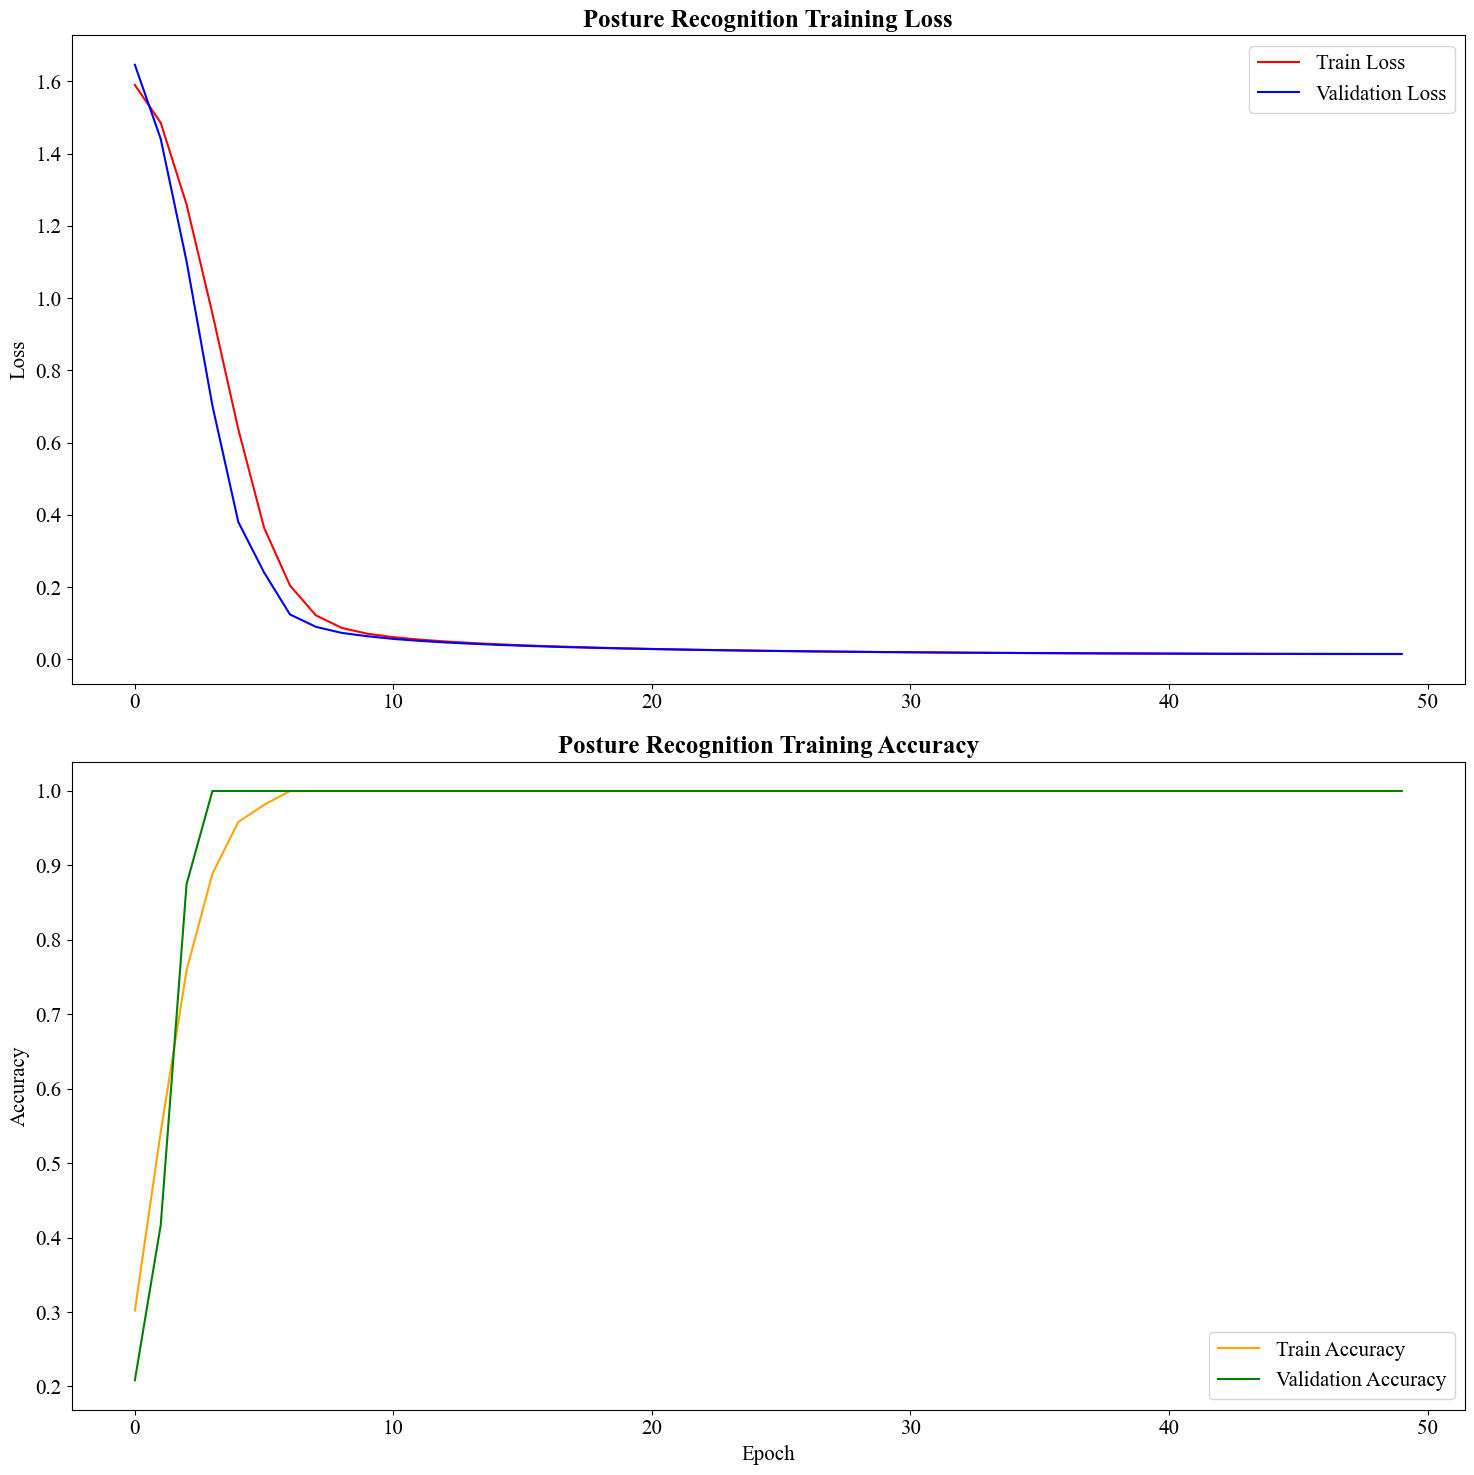

In [18]:
import pickle
import matplotlib.pyplot as plt

# Set global font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

with open(history_path, "rb") as f:
    hist = pickle.load(f)

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

# Plot loss
axs[0].plot(hist["train_loss"], label="Train Loss", color='red')
axs[0].plot(hist["eval_loss"], label="Validation Loss", color='blue')
axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(hist["train_accuracy"], label="Train Accuracy", color='orange')
axs[1].plot(hist["eval_accuracy"], label="Validation Accuracy", color='green')
axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


### Video

## 5. Inferring

### Image

**Inference**

True label: Intrinsic_Plan
Predicted label: Intrinsic_Plan
True label: Hook_Hand
Predicted label: Hook_Hand
True label: Hand_Close
Predicted label: Hand_Close
True label: Intrinsic_Plan
Predicted label: Intrinsic_Plan
True label: Intrinsic_Plan
Predicted label: Intrinsic_Plan
True label: Hook_Hand
Predicted label: Hook_Hand
True label: Straight_Fist
Predicted label: Straight_Fist
True label: Hand_Open
Predicted label: Hand_Open
True label: Hook_Hand
Predicted label: Hook_Hand


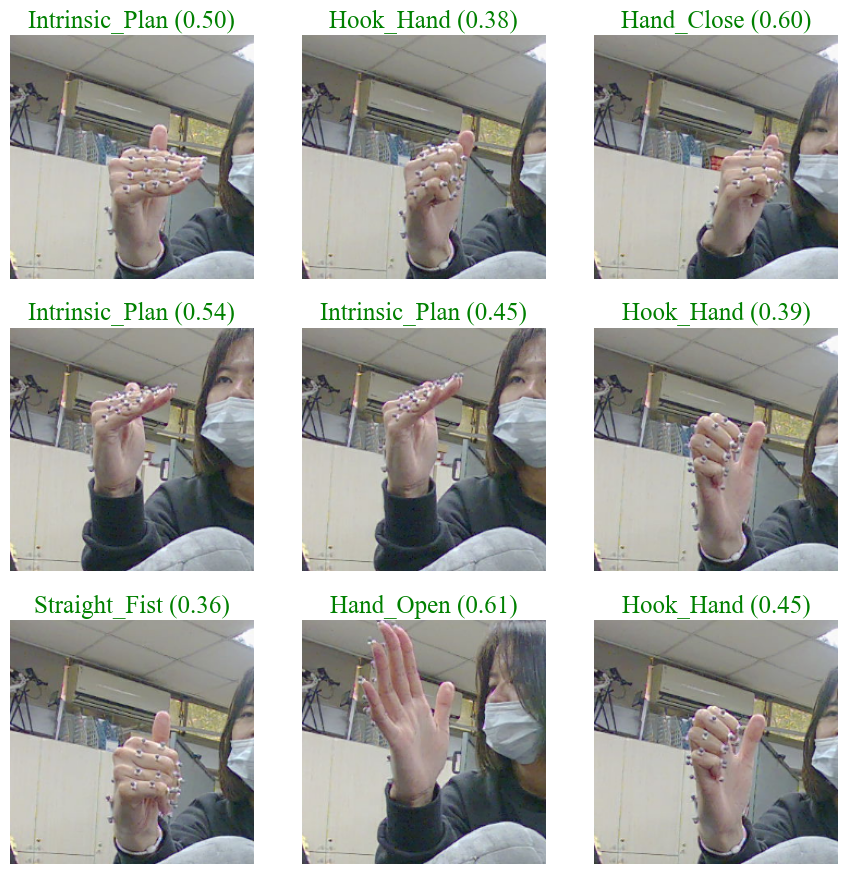

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from transformers import ViTForImageClassification, ViTImageProcessor

# Load model and processor
ckpt_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\image\20250419\vit-base-patch16-224-in21k-finetuned-pr240\checkpoint-96'
model = ViTForImageClassification.from_pretrained(ckpt_dir)
processor = ViTImageProcessor.from_pretrained(ckpt_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Prepare mean/std for un-normalization
mean = torch.tensor(processor.image_mean).view(1, 3, 1, 1).to(device)
std = torch.tensor(processor.image_std).view(1, 3, 1, 1).to(device)

# Sample 9 examples from test_ds
idxs = random.sample(range(len(test_ds)), k=min(9, len(test_ds)))

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, idx in zip(axes.ravel(), idxs):
    item = test_ds[idx]
    pixel_values = item["pixel_values"]  # Tensor [3, H, W]
    label_idx = item["labels"].item()      
    true_label = id2label[label_idx]

    # Run inference
    input_tensor = pixel_values.unsqueeze(0).to(device)  # [1, 3, H, W]
    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        probs = softmax(outputs.logits, dim=-1)
        pred_idx    = probs.argmax(dim=-1).item()
        pred_label  = id2label[pred_idx]
        confidence = probs[0, pred_idx].item()

    # Un-normalize for display
    img_tensor = input_tensor * std + mean
    img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f"{pred_label} ({confidence:.2f})", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()